In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean.cm as cmo
import netCDF4
import statsmodels.tsa.stattools as tools
import scipy
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import seaborn as sns  # for better style in plots
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr
from scipy.stats import multivariate_normal

In [3]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(1/16*x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [11]:
#1x1 degree grid from lon: 120° to 280° and lat: -30° to 30°
x1, x2 = 120, 280
y1, y2 = -16, 16

gn   = 1
nd   = 20
ntpd = 24

nx = (x2 - x1)*gn
ny = (y2 - y1)*gn
nt = nd*ntpd                 #iterate through N days to start; can adjust later if needed

lon_u = np.linspace(x1, x2, num=nx+1)
lon_v = np.linspace(x1, x2, num=nx)
lon_h = lon_v
lat_u = np.linspace(y1, y2, num=ny)
lat_v = np.linspace(y1, y2, num=ny+1)
lat_h = lat_u

lon_m = (1.11e5/gn)*np.cos(np.deg2rad(lat_u))
y_u   = (1.11e5/gn)*lat_u
y_v   = (1.11e5/gn)*lat_v

dy = 1.11e5/gn
dt = 86400/ntpd

u = np.zeros((nt, ny,   nx+1))
v = np.zeros((nt, ny+1, nx))
h = np.zeros((nt, ny,   nx)) 

h[0,:,:] = -250*matlab_style_gauss2D(shape=(ny,nx+20*gn),sigma=3.75*gn)[:,20*gn:] #initial thermocline depression as per slide 8 in note set 7
#h[0,:,:] = np.where(h[0,:,:] < -.01, h[0,:,:], 0)

a = 1/(86400*15) #u damping; should remove gravity waves
b = 1/(86400*15) #v damping; should remove gravity waves
c = 1/(86400*60) #h damping; should remove gravity waves

beta = 2.2e-11    #s-1m-1
g    = 9.8*2/1000
D1   = np.linspace(150, 150, num=nx)

In [12]:
for t in np.arange(nt-1):
    for j in np.arange(ny):
        dx = lon_m[j]
        for i in np.arange(nx): 
            if (t == 0):
                if (i == 0 and j == 0):
                    u[t+1,j,i] = 0
                    v[t+1,j,i] = 0
                    h[t+1,j,i] = (1 - c*dt)*h[t,j,i] - dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                elif (i == 0 and j > 0):
                    u[t+1,j,i] = 0
                    v[t+1,j,i] = (1 - b*dt)*v[t,j,i] - beta*y_v[j]*dt/4*(u[t,j,i] + u[t,j,i+1] + u[t,j-1,i] + u[t,j-1,i+1]) - dt*g/dy*(h[t,j,i] - h[t,j-1,i])
                    h[t+1,j,i] = (1 - c*dt)*h[t,j,i] - dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                elif (i > 0 and j == 0):
                    u[t+1,j,i] = (1 - a*dt)*u[t,j,i] + beta*y_u[j]*dt/4*(v[t,j,i] + v[t,j+1,i] + v[t,j,i-1] + v[t,j+1,i-1]) - dt*g/dx*(h[t,j,i] - h[t,j,i-1])
                    v[t+1,j,i] = 0
                    h[t+1,j,i] = (1 - c*dt)*h[t,j,i] - dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                else:
                    u[t+1,j,i] = (1 - a*dt)*u[t,j,i] + beta*y_u[j]*dt/4*(v[t,j,i] + v[t,j+1,i] + v[t,j,i-1] + v[t,j+1,i-1]) - dt*g/dx*(h[t,j,i] - h[t,j,i-1])
                    v[t+1,j,i] = (1 - b*dt)*v[t,j,i] - beta*y_v[j]*dt/4*(u[t,j,i] + u[t,j,i+1] + u[t,j-1,i] + u[t,j-1,i+1]) - dt*g/dy*(h[t,j,i] - h[t,j-1,i])
                    h[t+1,j,i] = (1 - c*dt)*h[t,j,i] - dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
            
            else:
                if (i == 0 and j == 0):
                    u[t+1,j,i] = 0
                    v[t+1,j,i] = 0
                    h[t+1,j,i] = (1 - c*2*dt)*h[t-1,j,i] - 2*dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                elif (i == 0 and j > 0):
                    u[t+1,j,i] = 0
                    v[t+1,j,i] = (1 - b*2*dt)*v[t-1,j,i] - beta*y_v[j]*dt/2*(u[t,j,i] + u[t,j,i+1] + u[t,j-1,i] + u[t,j-1,i+1]) - 2*dt*g/dy*(h[t,j,i] - h[t,j-1,i])
                    h[t+1,j,i] = (1 - c*2*dt)*h[t-1,j,i] - 2*dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                elif (i > 0 and j == 0):
                    u[t+1,j,i] = (1 - a*2*dt)*u[t-1,j,i] + beta*y_u[j]*dt/2*(v[t,j,i] + v[t,j+1,i] + v[t,j,i-1] + v[t,j+1,i-1]) - 2*dt*g/dx*(h[t,j,i] - h[t,j,i-1])
                    v[t+1,j,i] = 0
                    h[t+1,j,i] = (1 - c*2*dt)*h[t-1,j,i] - 2*dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
                else:
                    u[t+1,j,i] = (1 - a*2*dt)*u[t-1,j,i] + beta*y_u[j]*dt/2*(v[t,j,i] + v[t,j+1,i] + v[t,j,i-1] + v[t,j+1,i-1]) - 2*dt*g/dx*(h[t,j,i] - h[t,j,i-1])
                    v[t+1,j,i] = (1 - b*2*dt)*v[t-1,j,i] - beta*y_v[j]*dt/2*(u[t,j,i] + u[t,j,i+1] + u[t,j-1,i] + u[t,j-1,i+1]) - 2*dt*g/dy*(h[t,j,i] - h[t,j-1,i])
                    h[t+1,j,i] = (1 - c*2*dt)*h[t-1,j,i] - 2*dt*D1[i]*((u[t,j,i+1] - u[t,j,i])/dx + (v[t,j+1,i] - v[t,j,i])/dy)
            
    sigma_h  = [0.2, 0.15]
    sigma_uv = [0.2, 0.15]
    u[t+1,:,1:nx-1] = scipy.ndimage.filters.gaussian_filter(u[t+1,:,1:nx-1], sigma_uv, mode='constant')  
    v[t+1,1:ny-1,:] = scipy.ndimage.filters.gaussian_filter(v[t+1,1:ny-1,:], sigma_uv, mode='constant')
    h[t+1,:,:]      = scipy.ndimage.filters.gaussian_filter(h[t+1,:,:],      sigma_h,  mode='constant')

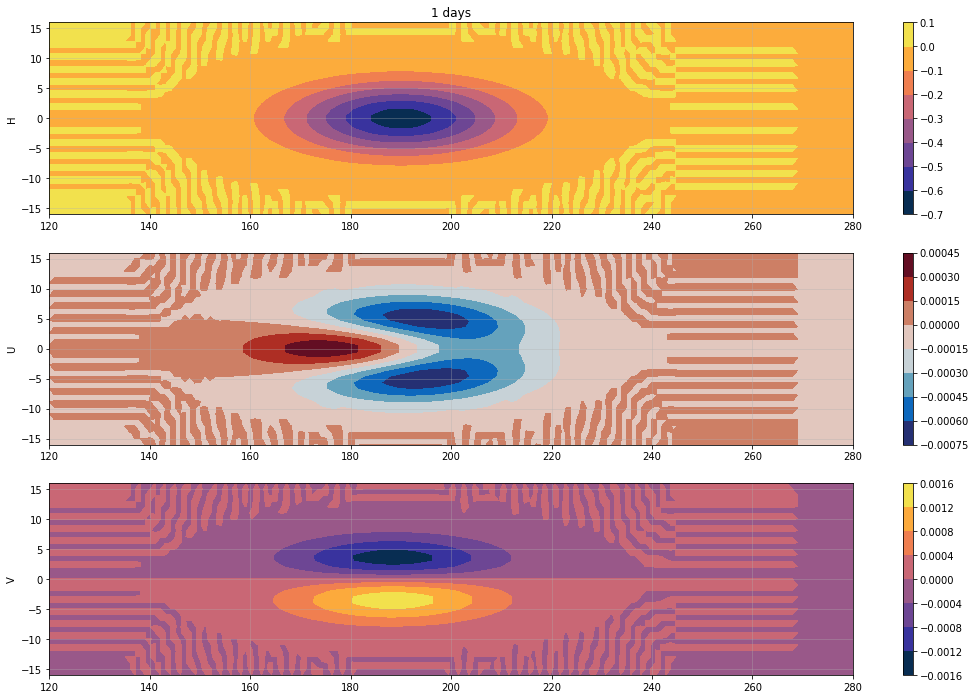

In [15]:
fig = plt.figure(figsize=(18,12))

day = 1
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
pc1 = ax1.contourf(lon_h, lat_h, h[day*ntpd-1,:,:], cmap=cmo.thermal)
pc2 = ax2.contourf(lon_u, lat_u, u[day*ntpd-1,:,:], cmap=cmo.balance)
pc3 = ax3.contourf(lon_v, lat_v, v[day*ntpd-1,:,:], cmap=cmo.thermal)
fig.colorbar(pc1, ax=ax1)
fig.colorbar(pc2, ax=ax2)
fig.colorbar(pc3, ax=ax3)
ax1.set_title(str(day) + ' days')
ax1.set_ylabel('H')
ax2.set_ylabel('U')
ax3.set_ylabel('V')
ax1.grid(alpha=.4)
ax2.grid(alpha=.4)
ax3.grid(alpha=.4)

Text(0, 0.5, 'V')

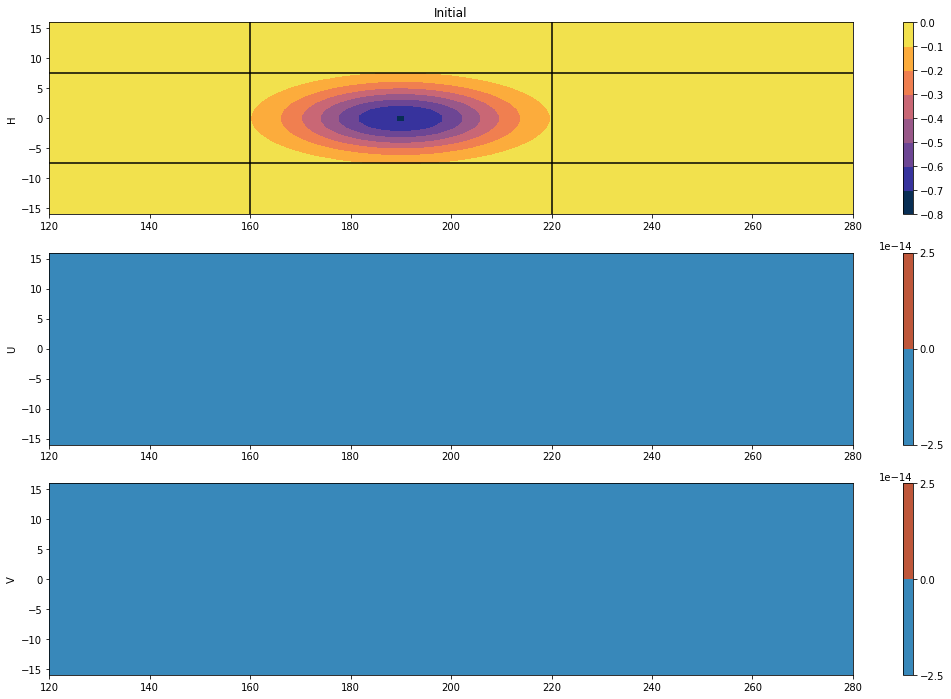

In [10]:
fig = plt.figure(figsize=(18,12))

test = np.where(h[0,:,:] < -.01, h[0,:,:], 0)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
pc1 = ax1.contourf(lon_h, lat_h, test, cmap=cmo.thermal)
ax1.plot(lon_h, np.zeros(160) + 7.5,color='black')
ax1.plot(lon_h, np.zeros(160) - 7.5,color='black')
ax1.axvline(x=160,color='black')
ax1.axvline(x=220,color='black')
pc2 = ax2.contourf(lon_u, lat_u, u[0,:,:], cmap=cmo.balance)
pc3 = ax3.contourf(lon_v, lat_v, v[0,:,:], cmap=cmo.balance)
fig.colorbar(pc1, ax=ax1)
fig.colorbar(pc2, ax=ax2)
fig.colorbar(pc3, ax=ax3)
ax1.set_title('Initial')
ax1.set_ylabel('H')
ax2.set_ylabel('U')
ax3.set_ylabel('V')